# Modify boundary conditions


In [1]:
# make the notebook more readable:
import warnings
warnings.filterwarnings('ignore')

Slurm Header

In [2]:
#!/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/bin/python
#SBATCH --partition=compute
#SBATCH --account=mh0926
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=24
#SBATCH --time=04:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j_%x.log
#SBATCH --error=%j_%x.log

## Make a list of files <a class="anchor" id="filelist"></a>

In [3]:
import os
import sys
import subprocess as sub

import xarray as xr
import random
import hashlib

# General utilities
from numpy import array_split as list_split
from function_timer import function_timer

def get_hash(string):
    # https://www.pythoncentral.io/hashing-strings-with-python/
    hash_object = hashlib.sha1(string.encode())
    return hash_object.hexdigest()

def basename(path, extension=True):
    if extension: 
        return os.path.basename(path)
    else: # removes extension
        return os.path.splitext(os.path.basename(path))[0]

def extension(path):
    return os.path.splitext(path)[1]

def is_netcdf(f):
    return extension(f) == '.nc'

 * a crawler to generate a file list
 * a function to join information about the variable name with the file name
   (e.g. temperature is called `t` in the initial field, but `temp` in the lateral boundaries)
 * a function to get a list of directory names without doubles, for directory creation

In [4]:
# File list management
import os 

class Registry:
    temp_path = '~/temporary-file-structure'
    source_path = None
    output_path = None
    file_list = []

    def __init__(self, source_path, output_path=None, temp_path=None):
        self.source_path = source_path
        self.output_path = output_path
        if temp_path:
            self.temp_path = temp_path
    
    def set_temp_path(self, path):
        self.temp_path = path
    def get_temp_path(self):
        return self.temp_path
    def set_source_path(self, path):
        self.source_path = path
    def get_source_path(self):
        return self.source_path
    def set_output_path(self, path):
        self.output_path = path
    def get_output_path(self):
        return self.output_path

    def list_files(self, dirname):
        '''
        crawls the directory and returns a list of files in all subdirectories. The returned 
        paths are relative to `self.source_path`
        '''
        file_list = []
        for root, directories,files in os.walk(os.path.join(self.source_path, dirname)):
            for name in files: 
                if is_netcdf(name):
                    path = os.path.join(os.path.relpath(root, start=self.source_path), name)
                    file_list.append(path)
        return file_list
    
    def add_filelist(self, dirname):
        '''
        adds files in directory to internal file list
        '''
        self.file_list = self.file_list + self.list_files(dirname)
    
    def get_filelist(self):
        return self.file_list
    
    @staticmethod
    def dirnames_from_filelist(file_list):
        return set([os.path.dirname(f) for f in file_list])

    def create_dir_structure(self):
        assert self.temp_path != None
        assert self.output_path != None
        # assertIsNotNone(self.output_path)
        
        dirnames = self.dirnames_from_filelist(self.file_list)

        os.makedirs(temp_path, exist_ok=True)
        for name in dirnames:
            dirname = os.path.join(self.output_path, name)
            os.makedirs(dirname, exist_ok=True)

def get_filelist(lost_path, conserved_path):
    '''
    crawls the directory `lost_path`+`conserved_path` and 
    returns a list of files in all subdirectories. The returned 
    paths are relative paths to `lost_path`.
    '''
    file_list = []
    for root, directories,files in os.walk(os.path.join(lost_path, conserved_path)):
        for name in files: 
            if is_netcdf(name):
                path = os.path.join(os.path.relpath(root, start=lost_path), name)
                file_list.append(path)
    return file_list

def create_pathdict(file_list, varname):
    '''
    takes a list of files and 
    returns a including information about the variable name to be modified
    '''
    path_dict = list()
    for f in file_list:
        path_dict.append({'file' : f, 'var' : varname})
    return path_dict
    
def get_pathdict(lost_path, conserved_path, varname):
    '''
    returns a list of relative paths of files and added information about the varname 
    output format: [{'file': str(), 'var': str()}]
    '''
    return create_pathdict(get_filelist(lost_path, conserved_path), varname)

def dirnames_from_pathdict(pathdict):
    dirnames = set()
    for entry in pathdict:
        dirnames.add(os.path.dirname(entry['file']))
    return(dirnames)

def create_dir_structure(dirnames):
    pass

In [5]:
source_path = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/'
added_value = 1
randomfunnyname = 'amogus'
target_path = f'/work/mh0926/m300872/{randomfunnyname}les_plus{added_value}_forcing/'
temp_path   = '/work/mh0926/m300872/warm_eurec4a/temp_' + randomfunnyname


def xr_add(value, f, varname, source_path, target_path):
    data = xr.open_dataset(os.path.join(source_path, f))
    data[varname] += value
    data.to_netcdf(os.path.join(target_path, f))


rrr = Registry(source_path,target_path,temp_path)
rrr.add_filelist('latbc')
path = rrr.get_filelist()[1]
# xr_add(4, rrr.get_filelist()[1], 'SST', rrr.get_source_path(), rrr.get_temp_path())
path

'latbc/20200119/latbc_EUREC4A_PR1250m_DOM01_2020011905.nc'

## Overview over boundary conditions variables <a class="anchor" id="variables"></a>

In [6]:
import xarray as xr
import numpy  as np
import os

def eureca_grid(domain='DOM01'):
    return xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{domain}.zarr")

def ncells_eureca_grid(domain='DOM01'):
    return eureca_grid(domain).cell.size

def n_elements(dataset):
    sizes = [f[v].size for v in list(f)]
    return np.sum(sizes)

def gb(byte):
    return byte / 1e9
def tb(byte):
    return byte / 1e12

def size_estimate(elements,gb=True,precision='sp'):
    if precision in ['dp','DP','double']:
        byte_per_element = DP_BYTES
    else:
        byte_per_element = SP_BYTES
    x = elements * byte_per_element
    if gb: return gb(x)
    else: return x

# bytes per float, double and single precision (DP,SP)
DP_BYTES = 64 / 8
SP_BYTES = 32 / 8

source_path = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/'
example_files = {'sst'  : 'sst_sic/data/sst_sic_DOM01.nc',
                'initc' : 'initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc',
                'latbc' : 'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc'}

for boundary, path in example_files.items():
    fullpath = os.path.join(source_path, path)
    nvars = len(list(xr.open_dataset(fullpath)))
    print(boundary.ljust(8), f"{gb(os.path.getsize(fullpath)):.3f} GB".rjust(10), f"{str(nvars).rjust(4)} variables", ' ',path)
    # print(f"{str(nvars).rjust(6)} variables:", "\t", end='')
    # for var in list(xr.open_dataset(fullpath)):
    #     print(var, end=', ')
    # print('\n\n')
print()

for boundary, path in example_files.items():
    fullpath = os.path.join(source_path, path)
    # print(boundary.ljust(8), f"{gb(os.path.getsize(fullpath)):.3f} GB".rjust(10), f"{str(nvars).rjust(4)} variables", ' ',path)
    print(f"{boundary} variables:")
    for var in list(xr.open_dataset(fullpath)):
        try:
            print('\t',var.ljust(12), xr.open_dataset(fullpath)[var].attrs['long_name'])
        except: pass
    print()


sst       32.896 GB    4 variables   sst_sic/data/sst_sic_DOM01.nc
initc     22.653 GB   39 variables   initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc
latbc      0.587 GB   15 variables   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc

sst variables:
	 SST          Skin temperature
	 SIC          sea_ice_are_fraction

initc variables:
	 theta_v      virtual potential temperature
	 z_ifc        geometric height at half level center
	 rho          density
	 w            Vertical velocity
	 tke          turbulent kinetic energy
	 qv           Specific humidity
	 qc           specific cloud water content
	 qi           specific cloud ice content
	 qr           rain mixing ratio
	 qs           snow mixing ratio
	 u            Zonal wind
	 v            Meridional wind
	 t            Temperature
	 p            Pressure
	 sp           surface pressure
	 vn           velocity normal to edge
	 fr_seaice    fraction of sea ice
	 t_ice        sea/lake-ice temperature
	 h_ice   

## File sizes, expected computation time  <a class="anchor" id="filesize"></a>

## From specific to relative humidity and back  <a class="anchor" id="rhconversion"></a>

The python package `metpy` offers a set of formulas to convert different atmospheric variables. To test it, we convert specific humidity (`qv`) to relative humidity (`rh`) and back. As there is no *specific humidity from relative humidity* function, we have to make an extra step over the volume mixing ratio (`w`). The result looks good: both profiles overlay perfectly.

In [7]:
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

source_path = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/'
rrr.add_filelist('latbc')
path = rrr.get_filelist()[1]

f = xr.open_dataset(os.path.join(source_path, path))
cell = np.random.randint(len(f.ncells)); print('random cell number: ',cell)

p  = f['pres'].isel(ncells=cell) * units('pascal')
t  = f['temp'].isel(ncells=cell) * units('kelvin')
qv = f['qv'].isel(ncells=cell)   # ratio of water vapor mass to total moist air parcel mass

# another version of specific humidity, converted to relative humidity and back:
rh = mpcalc.relative_humidity_from_specific_humidity(p, t, qv)
eps = mpcalc.mixing_ratio_from_relative_humidity(p, t, rh)
qv_2 = mpcalc.specific_humidity_from_mixing_ratio(eps)

random cell number:  88485


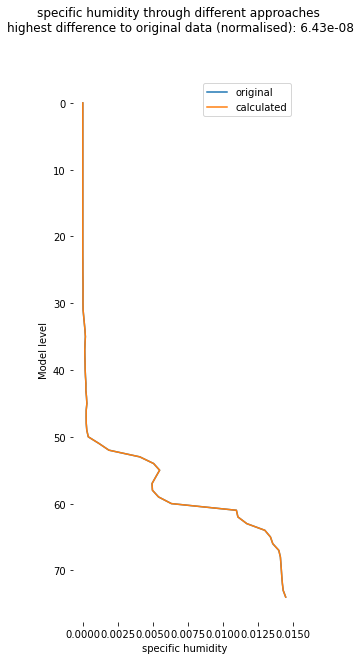

In [8]:
import matplotlib.pyplot as plt
import plot_utils as pu

def plot_profile(ax, x, xlabel=None, display_legend=False, inverty=True, **kwargs):
    y = range(len(x))
    ax.plot(x,y,**kwargs)
    if inverty: ax.invert_yaxis()
    if display_legend: ax.legend()
    if xlabel: ax.set_xlabel(xlabel)
    pu.remove_ticks(ax, ['left', 'right'])
    pu.remove_spines(ax)
    return ax

fig, ax = plt.subplots(1,1, figsize=(4,10))
title  = f'specific humidity through different approaches \n'
title += f'highest difference to original data (normalised): '
title += f'{np.max(np.abs(qv_2 - qv).values) / np.max(np.abs(qv).values):.2e}'
fig.suptitle(title)

plot_profile(ax, np.ravel(qv.values), label='original')
plot_profile(ax, np.ravel(qv_2.values), label='calculated', inverty=False, display_legend=True)

ax.set_ylabel('Model level')
ax.set_xlabel('specific humidity')
ax.tick_params(left=True, labelleft=True)
plt.show()

3956367


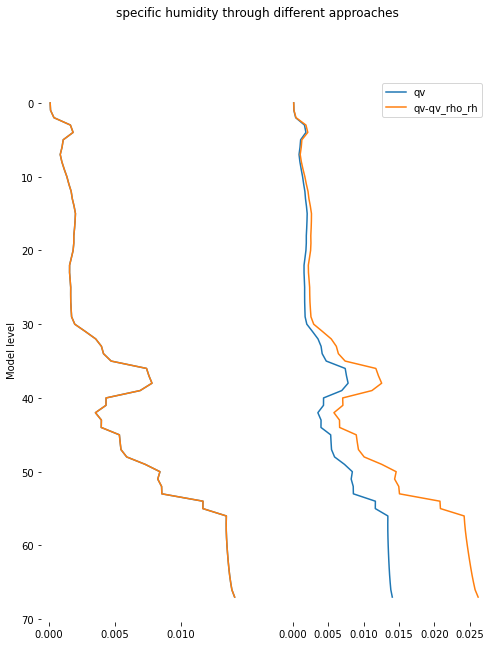

In [9]:

filename = '/work/mh1126/m300872/eureca_icon/EUREC4A/run/../experiments/r02EUREC4A/rEUREC4A_DOM01_3D_20200109T120000Z.nc'
f = xr.open_dataset(filename)
rand = np.random.randint(np.ravel(f.ncells.values.shape)[0]); print(rand)

p     = f['pres'].isel(ncells=rand) * units('pascal')
t     = f['temp'].isel(ncells=rand) * units('kelvin')
rho   = f['rho'].isel(ncells=rand)

# original data
qv = f['qv'].isel(ncells=rand)   # ratio of water vapor mass to total moist air parcel mass
# conversion to relative humidity (over mixing ratio) and back
rh_qv = mpcalc.relative_humidity_from_specific_humidity(p, t, qv)
eps_rh_qv = mpcalc.mixing_ratio_from_relative_humidity(p, t, rh_qv)
qv_eps_rh_qv = mpcalc.specific_humidity_from_mixing_ratio(eps_rh_qv)
# approach over 
e_s   = mpcalc.saturation_vapor_pressure(t)
vmr = (rh_qv * e_s / p)
qv_rho_rh = rho * vmr 

fig, axs = plt.subplots(1,2, figsize=(8,10))
fig.suptitle('specific humidity through different approaches')

plot_profile(axs[0], np.ravel(qv.values), label='qv')
plot_profile(axs[0], np.ravel(qv_eps_rh_qv.values), label='qv_eps_rh_qv', inverty=False)
plot_profile(axs[1], np.ravel(qv.values), label='qv')
plot_profile(axs[1], np.ravel(qv_rho_rh.values), label='qv-qv_rho_rh', display_legend=True, inverty=False)



axs[0].set_ylabel('Model level')
axs[0].tick_params(left=True, labelleft=True)
plt.show()

## Apply heating to vertical profile  <a class="anchor" id="heating"></a>

We apply a warming to the atmospheric field in increasing complexity. We will first work on single columns, and later expand to 3D fields. And we will look at different heating profiles:
 * A simple +X kelvin approach
 * +X kelvin below the cold-point tropopause
 * Heating along the moist adiabat for a +X warmer surface

### Uniform warming  <a class="anchor" id="heatuni"></a>

random cell number:  153317 



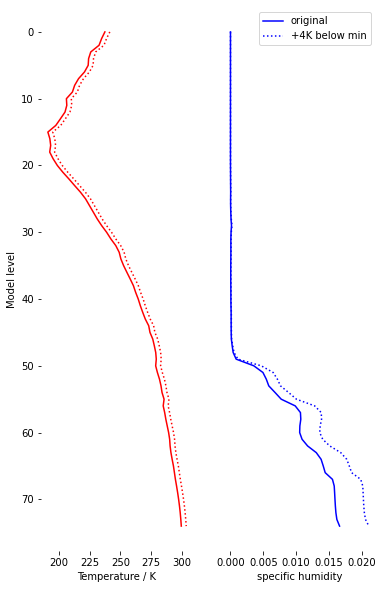

In [10]:
import matplotlib.pyplot as plt
import plot_utils as pu

def get_example_profile(cell=None):
    example_file = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/latbc/20200119/latbc_EUREC4A_PR1250m_DOM01_2020011905.nc'
    f = xr.open_dataset(example_file)
    if not cell:
        cell = np.random.randint(len(f.ncells))
        print('random cell number: ',cell,'\n')
    return f.isel(ncells=cell)

import xarray as xr
import numpy as np

def add_4(data):
    constant = 4
    data_new = data.copy()
    data_new['temp'].values = data_new['temp'].values + constant
    return data_new

import metpy.calc as mpcalc
from metpy.units import units

def change_t_conserve_rh(data, raise_t_function):
    data_new = raise_t_function(data)
    p  = data['pres'].values * units('pascal')
    t  = data['temp'].values * units('kelvin')
    t_new = data_new['temp'].values * units('kelvin')
    qv = data['qv'  ].values # ratio of water vapor mass to total moist air parcel mass
    
    rh = mpcalc.relative_humidity_from_specific_humidity(p, t, qv)
    eps = mpcalc.mixing_ratio_from_relative_humidity(p, t_new, rh)
    qv_new = mpcalc.specific_humidity_from_mixing_ratio(eps)
    
    data_new['temp'].values = t_new.magnitude
    data_new['qv'  ].values = qv_new.magnitude
    return data_new

f1 = get_example_profile()
f2 = change_t_conserve_rh(f1, add_4)

m = 2
fig, axs = plt.subplots(1,m, figsize=(m*3,10))

ax = axs[0]
plot_profile(ax, np.ravel(f1['temp'].values),'Temperature / K', color='red')
plot_profile(ax, np.ravel(f2['temp'].values), color='red', ls=':', inverty=False)
ax = axs[1]
plot_profile(ax, np.ravel(f1['qv'].values),'specific humidity', color='blue', label='original')
plot_profile(ax, np.ravel(f2['qv'].values), color='blue', ls=':', inverty=False, label='+4K below min')
ax.legend()

axs[0].set_ylabel('Model level')
axs[0].tick_params(left=True, labelleft=True)
plt.show()

### Uniform warming of troposphere only  <a class="anchor" id="heattropos"></a>

random cell number:  164436 



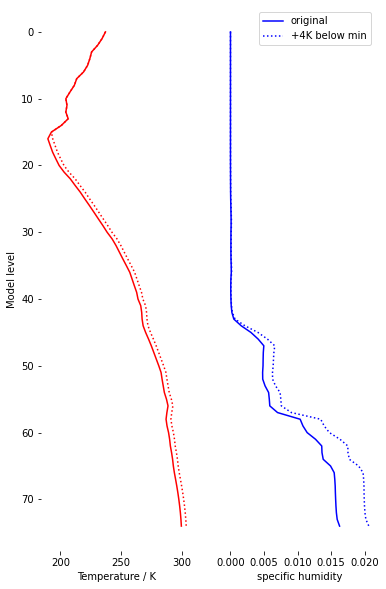

In [11]:
def add_4_below_coldpoint(data):
    data_new = data.copy()
    cold_point = data_new['temp'].argmin().values
    data_new['temp'][...,cold_point::] += 4
    return data_new

f1 = get_example_profile()
f2 = change_t_conserve_rh(f1, add_4_below_coldpoint)

m = 2
fig, axs = plt.subplots(1,m, figsize=(m*3,10))

ax = axs[0]
plot_profile(ax, np.ravel(f1['temp'].values),'Temperature / K', color='red')
plot_profile(ax, np.ravel(f2['temp'].values), color='red', ls=':', inverty=False)
ax = axs[1]
plot_profile(ax, np.ravel(f1['qv'].values),'specific humidity', color='blue', label='original')
plot_profile(ax, np.ravel(f2['qv'].values), color='blue', ls=':', inverty=False, label='+4K below min')
ax.legend()

axs[0].set_ylabel('Model level')
axs[0].tick_params(left=True, labelleft=True)
plt.show()

### Warming along moist adiabat  <a class="anchor" id="heatadiabat"></a>

random cell number:  6335 



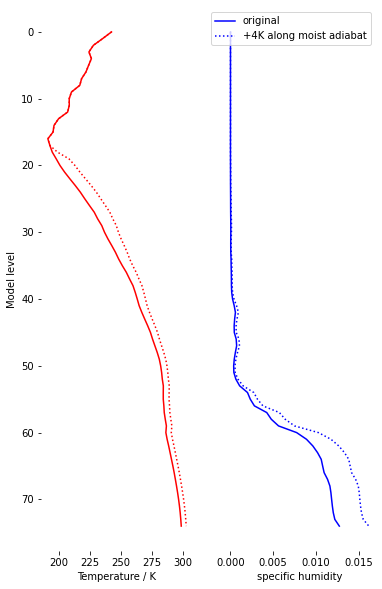

In [15]:
from konrad.lapserate import get_moist_adiabat
# get_moist_adiabat(p, p_s=None, T_s=300.0, T_min=155.0)
# https://konrad.readthedocs.io/_modules/konrad/lapserate.html#get_moist_adiabat
def moist_adiabat(single_cell_dataset, temp_name='temp', pres_name='pres'):
    p     = np.flip(np.ravel(single_cell_dataset[pres_name].values))
    p_s   = p[0]
    t     = np.flip(np.ravel(single_cell_dataset[temp_name].isel(ncells=cell)))
    T_s   = t[0]
    T_min = np.min(t)
    return np.flip(get_moist_adiabat(p,  T_s=T_s, T_min=T_min))

def add_4_along_adiabat(data, temp_name='temp', pres_name='pres'):
    data_new = data.copy()
    
    p     = np.flip(np.ravel(data[pres_name].values))
    p_s   = p[0]
    t     = np.flip(np.ravel(data[temp_name].values))
    T_s   = t[0]
    T_min = np.min(t)
    cold_adiabat = np.flip(get_moist_adiabat(p,  T_s=T_s, T_min=T_min))
    hot_adiabat  = np.flip(get_moist_adiabat(p,  T_s=T_s+4, T_min=T_min))

    data_new[temp_name].values += (hot_adiabat - cold_adiabat)
    return data_new

f1 = get_example_profile()
f2 = change_t_conserve_rh(f1, add_4_along_adiabat)

m = 2
fig, axs = plt.subplots(1,m, figsize=(m*3,10))

ax = axs[0]
plot_profile(ax, np.ravel(f1['temp'].values),'Temperature / K', color='red')
plot_profile(ax, np.ravel(f2['temp'].values), color='red', ls=':', inverty=False)
ax = axs[1]
plot_profile(ax, np.ravel(f1['qv'].values),'specific humidity', color='blue', label='original')
plot_profile(ax, np.ravel(f2['qv'].values), color='blue', ls=':', inverty=False, label='+4K along moist adiabat')
ax.legend()

axs[0].set_ylabel('Model level')
axs[0].tick_params(left=True, labelleft=True)
plt.show()

### Comparison  <a class="anchor" id="heatcomparison"></a>

random cell number:  12886 



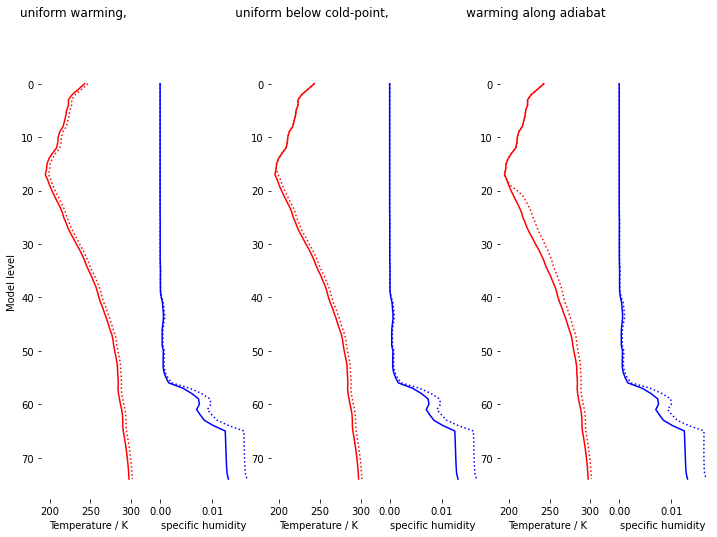

In [13]:
f0 = get_example_profile()

m = 6
fig, axs = plt.subplots(1,m, figsize=(m*2,8))

i = 0
for function in [add_4, add_4_below_coldpoint,add_4_along_adiabat]:
    f0 = get_example_profile(103940) # if i don't redo this every time, the results get messed up.... why? :sob:
    f1 = change_t_conserve_rh(f0, function)
    ax = axs[i]; i += 1
    plot_profile(ax, np.ravel(f0['temp'].values),'Temperature / K', color='red')
    plot_profile(ax, np.ravel(f1['temp'].values), color='red', ls=':', inverty=False)
    ax = axs[i]; i += 1
    plot_profile(ax, np.ravel(f0['qv'].values),'specific humidity', color='blue', label='original')
    plot_profile(ax, np.ravel(f1['qv'].values), color='blue', ls=':', inverty=False, label='modified')
    axs[i-2].tick_params(left=True, labelleft=True)

axs[0].set_ylabel('Model level')
fig.suptitle('uniform warming,                            uniform below cold-point,                    warming along adiabat                           ')
plt.show()         

random cell number:  133514 

0 6 6
1 8 8
2 10 10
3 12 12
4 15 15
5 17 17
6 20 20
7 24 24
8 28 28
9 32 32
10 37 37
11 42 42
12 48 48
13 55 55
14 62 62
15 70 70
16 78 78
17 88 88
18 98 98
19 109 109
20 121 121
21 133 133
22 146 146
23 160 160
24 175 175
25 189 189
26 205 205
27 221 221
28 238 238
29 255 255
30 273 273
31 291 291
32 309 309
33 328 328
34 347 347
35 367 367
36 386 386
37 406 406
38 426 426
39 447 447
40 467 467
41 487 487
42 508 508
43 529 529
44 549 549
45 570 570
46 591 591
47 611 611
48 632 632
49 652 652
50 672 672
51 692 692
52 712 712
53 732 732
54 751 751
55 770 770
56 789 789
57 807 807
58 825 825
59 843 843
60 860 860
61 876 876
62 892 892
63 907 907
64 922 922
65 935 935
66 948 948
67 961 961
68 972 972
69 982 982
70 992 992
71 1000 1000
72 1007 1007
73 1012 1012
74 1015 1015


NameError: name 's' is not defined

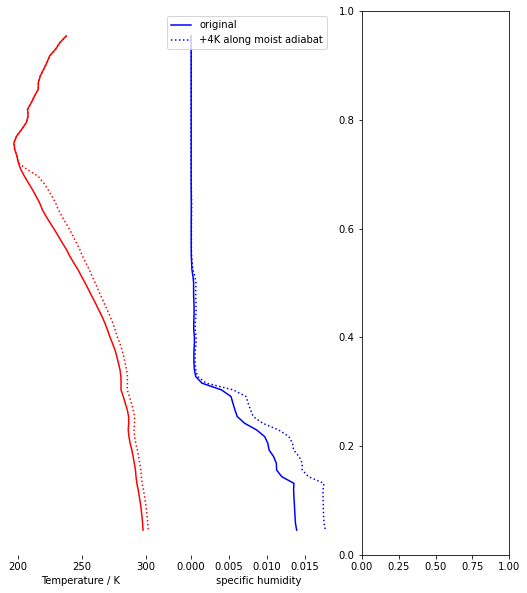

In [14]:


f1 = get_example_profile()
f2 = change_t_conserve_rh(f1, add_4_along_adiabat)

# # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.static_stability.html
# s  = [mpcalc.static_stability(np.ravel(f1['pres'].values) * units('pascal'),
#                               np.ravel(f1['temp'].values) * units('kelvin')),
#       mpcalc.static_stability(np.ravel(f2['pres'].values) * units('pascal'),
#                               np.ravel(f2['temp'].values) * units('kelvin'))]

p1 = np.ravel(f1['pres'].values)
p2 = np.ravel(f2['pres'].values)
# for i in range(len(p1)):
#     print(i, int(p1[i]/100), int(p2[i]/100))
    
m = 3
fig, axs = plt.subplots(1,m, figsize=(m*3,10))

ax = axs[0]
plot_profile(ax, np.ravel(f1['temp'].values),'Temperature / K', color='red')
plot_profile(ax, np.ravel(f2['temp'].values), color='red', ls=':', inverty=False)
ax = axs[1]
plot_profile(ax, np.ravel(f1['qv'].values),'specific humidity', color='blue', label='original')
plot_profile(ax, np.ravel(f2['qv'].values), color='blue', ls=':', inverty=False, label='+4K along moist adiabat')
ax.legend()
ax = axs[2]
plot_profile(ax, s[0],'stability', color='blue', label='original')
plot_profile(ax, s[1], color='blue', ls=':', inverty=False, label='+4K along moist adiabat')
# plot_profile(ax, np.ravel(f2['qv'].values), color='blue', ls=':', inverty=False, label='+4K along moist adiabat')
# ax.legend()

axs[0].set_ylabel('Model level')
axs[0].tick_params(left=True, labelleft=True)
plt.show()

## Remnants of a run script

In [ ]:
@function_timer
def add_to_var(value, f, varname, source_path, target_path, temp_path, backend='xarray'):
# def add_to_var(value, f, source_path, target_path, temp_path, backend='cdo', remove_prognostic=False):
    print(f"add_to_var with {f},{value}, {backend}")
    if backend == 'xarray':
        xr_add(value, f, varname, source_path, target_path)
    # elif   backend == 'cdo':
    #     cdo_add(value, f, varname, source_path, target_path, temp_path)
    else:
        raise ValueError(f"unknown backend defined: {backend}")

def xr_add(value, f, varname, source_path, target_path):
    data = xr.open_dataset(os.path.join(source_path, f))
    data[varname] += value
    data.to_netcdf(os.path.join(target_path, f))

def slice_pathlist(pathlist):
    if len(sys.argv) == 2:
        if sys.argv[1] == 'pass' :
            return([])
        if sys.argv[1] == 'test' :
            # just uses one, for testing
            return(pathlist[0:1])
        if sys.argv[1] == 'full':
            return(pathlist)
        if sys.argv[1] == 'slice':
            # only perform on a part of the list, for parallelisation
            try:
                n, d = int(sys.argv[2]), int(sys.argv[3])
            except:
                print('usage: slice <int a> <int b>')
                print('will work on the a-th part of a subset if split into b equal parts')
            # use np.array_split (aka. list_split) to get a chunk of the list
            return(list(list_split(file_list, d)[n-1]))
        else:
            print(f'use one of the following arguments:')
            print(f'  pass  (no action)')
            print(f'  test  (only one file edited)')
            print(f'  full  (full list used)')
            print(f'  slice a b (use a-th of b equal subssets)')
            return None

def plusXK_argv(added_value, source_path, onlyatest=False):
    cdo_options = ['-P', '8']
    randomfunnyname = 'hahalol888'
    
    # source_path = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/'
    target_path = f'/work/mh0926/m300872/{randomfunnyname}les_plus{added_value}_forcing/'
    temp_path   = '/work/mh0926/m300872/temp_' + get_hash(randomfunnyname)
    
    paths = list()
    paths += get_pathdict('/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/','sst_sic/data/', 'SST')
    print(paths)
    paths += get_pathdict('/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/','initc/20200109/', 't')
    paths += get_pathdict('/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/','latbc/', 'temp')
    
    # to run in in the notebook:
    if onlyatest: paths = [paths[1], paths[0]]

    # create blank directory structure
    os.makedirs(temp_path, exist_ok=True)
    for name in dirnames_from_pathdict(paths):
        dirname = os.path.join(target_path, name)
        os.makedirs(dirname, exist_ok=True)
        
    if not onlyatest: paths = slice_pathlist(paths)
    
    print(f"file list length = {len(paths)}")
    for i,e in enumerate(paths):
        print(f"{i}, filename: {e['file']}")
        add_to_var(added_value, e['file'], e['var'], source_path, target_path, temp_path, backend='xarray')
        # add_to_var(added_value, e['path'], e['var'], source_path, target_path, temp_path, backend='cdo')

    # remove tempory folder
    command = ['rm', '-r', temp_path]
    sub.run(command)
        
    print('\ndone')
    
    
# ######  M A I N   #####
# if __name__ == "__main__":
#     # plusXK_argv(4, '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/', onlyatest=True)
#     plusXK_argv(4, '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/')


In [ ]:
250/600, 190/500


In [ ]:
cdo_options = ['-P', '8']
added_value = 4
randomfunnyname = 'hahalol888'
onlyatest = True

source_path = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/'
target_path = f'/work/mh0926/m300872/{randomfunnyname}les_plus{added_value}_forcing/'
temp_path   = '/work/mh0926/m300872/temp_' + get_hash(randomfunnyname)

paths = list()
paths += get_pathdict(source_path,'sst_sic/data/', 'SST')
paths += get_pathdict(source_path,'initc/20200109/', 't')
paths += get_pathdict(source_path,'latbc/', 'temp')

# to run in in the notebook:
# if onlyatest: paths = [paths[1], paths[0]]

os.makedirs(temp_path, exist_ok=True)
for name in dirnames_from_pathdict(paths):
    dirname = os.path.join(target_path, name)
    os.makedirs(dirname, exist_ok=True)

paths[0:10]

In [ ]:
pfade = list()
hasch = list()

for p in paths:
    pp = p['file']
    pfade.append(pp)
    hasch.append(get_hash(pp))
    
for i in range(10):
    print(hasch[i],pfade[i])


In [ ]:
import os

def gb(byte):
    return byte / 1e9
def tb(byte):
    return byte / 1e12
 
for p in pfade[0:10]:
    full_path = os.path.join(source_path, p)
    file_size = os.path.getsize(full_path)
    print(f"{p.ljust(30)} : {gb(file_size):.3f} GB")